In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz
from sklearn.linear_model import LinearRegression
import rdata

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Missing Data

An observed variable is very unusual 

Missing data is typical. If not normal

Observed data is special case: We trick ourselves into believing there is no error

Most data are missing most of the time

"Missing" data: Some cases unobserved

Not totally "missing": We know

1) constraints

2) relationships to other variables (through the causal model)

## Missing Data is Mundane

What to do with missing data?

Dropping cases with missing values sometimes justifiable

Right thing to do depends upon causal assumptions

**Imputation** often beneficial/necessary

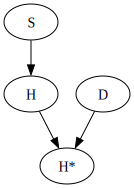

In [2]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW! 
H
#"Dog eats random homework"
#No biasing paths connecting H to S

Text(0.5, 1.0, 'Dog Usually Benign')

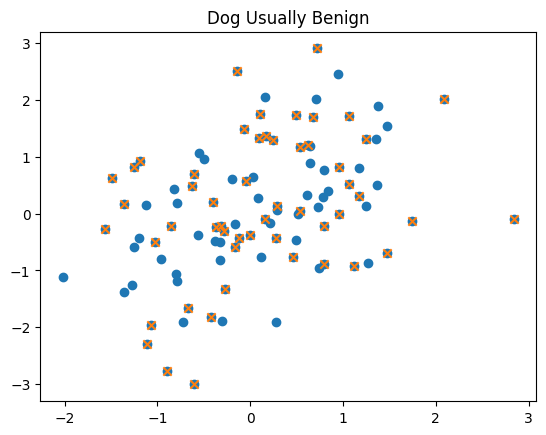

In [3]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,0.5,size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN


plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')
plt.title('Dog Usually Benign')

#Fitting a line through both sets will result in basically the same result
#Loss of precision, usually no bias

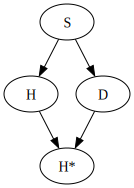

In [4]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW!
H.edge('S','D') #Student influences dog to eat homework! 

#S->D->H* Maybe a biasing path
H

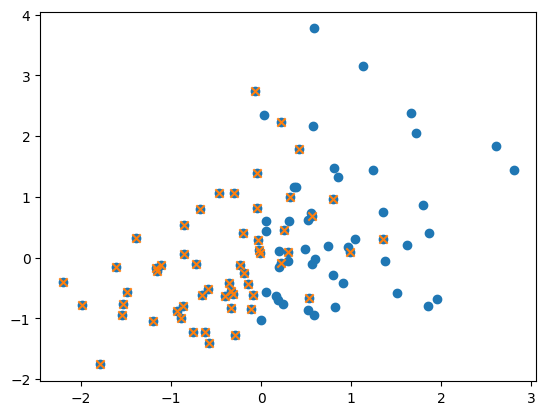

In [5]:
N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,[0.8 if x > 0 else 0 for x in S],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 

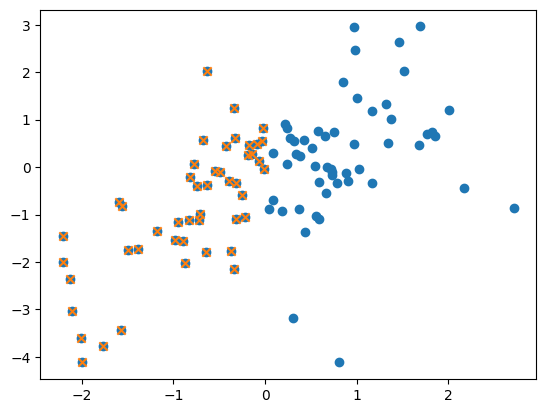

In [6]:
#Dog eats homework of students who study too much 
#Nonlinear with ceiling effect

N = 100
S = np.random.normal(size=100)
H = np.random.normal( 1 - np.exp(-0.7*S),size=100)

D = np.random.binomial(1,[1 if x > 0 else 0 for x in S],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 
#Look at curve now, 

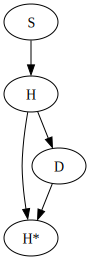

In [7]:
H = graphviz.Digraph()
H.edge('S','H') # Student -> Homework
H.edge('H','H*') # Descendent, has missing values of peopel who didn't turn in hw
H.edge('D','H*') #Dog eating HW! 
H.edge('H','D') # Dogs have a preference for homework
H
#"Dog eats conditional on homework"
#Usually not benign

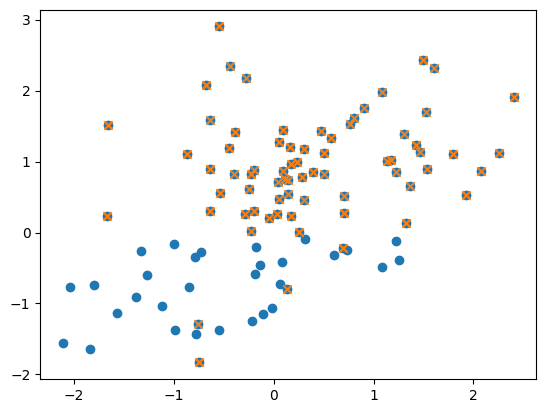

In [8]:
#Dog eats bad homework
# aka missing not at random 

N = 100
S = np.random.normal(size=100)
H = np.random.normal(0.5*S,size=100)

D = np.random.binomial(1,[0.9 if x < 0 else 0 for x in H],size=100)

Hstar = H.copy()
Hstar[D==1] = np.NaN

plt.scatter(S,H,marker='o')
plt.scatter(S,Hstar,marker='x')

#Crosses are observed, 
#Below average hw gets eaten! 

3 Idealized cases

1) Dog eats random homework: Dropping incomplete cases okay, but loss of efficiency. **Missing Completely at Random**

2) Dog eats conditional on cause: Correctly condition on cause **Missing at Random**

3) Dog eats homework itself: usually hopeless unless we can model the dog (e.g. survival analysis) **Missing not at Random**

Lots of variables where the value itself increases the probability that you will not observe it (i.e. best items get taken from a production site, can't observe the best items!)

Honest thing to do: usually report that 3. is hopeless, can't draw causal conclusions due to the missingness. Not always hopeless

## Bayesian Imputation

1) Dog eats random homework

2) Dog eats conditional on cause

Both imply need to impute or marginalize over missing values

**Bayesian Imputation**: Compute posterior probability distribution of missing values

**Marginalizing** unknowns: Averaging over distribution of missing values 

Causal model of all variables implies strategy for imputation

Technical obstacles exist!

Sometimes imputation is unnecessary, e.g. discrete parameters

Sometimes imputation is easier, eg. censored observations

## Phylogenetic regression

data(Primates301)

Life history traits

Mass g, brain cc, group size

Much missing data, measurement error, unobserved confounding

In [9]:
prim = pd.read_csv('Data/Primates301.csv',sep=';')
prim.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


## Imputing Primates 

Key Idea: Missing values already have probability distributions

Express causal model for each partially-observed variable

Replace each missing value with a parameter, let model do the rest

**Conceptually weird, technically awkward**

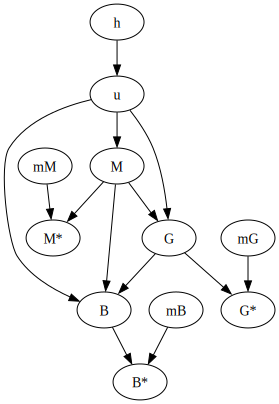

In [10]:
p = graphviz.Digraph()
p.edge('G','B')#Group size, Brain
p.edge('M','B')#Mass
p.edge('u','B')#Unobserved confounds
p.edge('M','G')
p.edge('u','G')
p.edge('u','M')
p.edge('h','u') #History
p.edge('G','G*') #Observed Group size (missing values)
p.edge('mG','G*') #Missingness influence
p.edge('M','M*')
p.edge('mM','M*')
p.edge('B','B*')
p.edge('mB','B*')
p

Whatever asssumptions about missingness, our goal is to use the causal model to infer probability distribution of each missing value.

Uncertainty in each missing value cascades through the entire model. 

### Model for B

$B \sim MVNormal(\mu,K)$

$\mu_i = \alpha + \beta_GG_i + \beta_MM_i$

$K = \eta^2exp(-\rho d_{i,j})$

$\alpha \sim Normal(0,1)$

$\beta_G,\beta_M \sim Normal(0,0.5)$

$\eta^2 \sim HalfNormal(1,0.25)$

$\rho \sim HalfNormal(3,0.25)$

A Bayesian model implies a complete joint distribution of all the variables. If any one of the variablesis unobserved, the other variables may have implications for it's distribution. This is how we infer those unobserved variables

### In the Bayesian view, the structure of the model comes from the scientific theory, once we have a sample, which variables have been observed/not observed determines which variables are data or parameters ###

### Model for G

$G \sim MVNormal(\mu,K)$

$\nu_i = \alpha_G + \beta_{MG}M_i$

$K_G = \eta_{G}^2exp(-\rho_G d_{i,j})$

$\alpha_G \sim Normal(0,1)$

$\beta_MG,\beta_M \sim Normal(0,0.5)$

$\eta_{G}^2 \sim HalfNormal(1,0.25)$

$\rho_G \sim HalfNormal(3,0.25)$

### Model for M

$M \sim MVNormal(0,K_M)$

$K_M = \eta_{M}^2 exp(-\rho_M d_{i,j})$

$\eta_{M}^2 \sim HalfNormal(1,0.25)$

$\rho_M \sim HalfNormal(3,0.25)$

Step by step: 

1) Ignore cases with missing B values (for now)

2) Impute G and M ignoring models for each

3) Impute G using model

4) Impute B, G, M using model

In [11]:
#Dropping missing brain cases 
primselected = prim[['body','group_size','brain']]
primBnan = primselected[primselected['brain'].notna()]
#primBnan = primBnan.fillna(1)

Going to do: When $G_i$ is observed, likelihood for standardized variable.

When $G_i$ missing, prior

In [12]:
parsed = rdata.parser.parse_file('Data/Primates301_distance_matrix.rda')
converted = rdata.conversion.convert(parsed)
Dmat0 = converted['Primates301_distance_matrix']

In [13]:
scale(np.log(primBnan['body'])).shape#.reshape(-1, 1).shape

(184,)

In [14]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes,M,G):
        self.intercept = intercept
        self.slopes = slopes
        self.M      = M
        self.G      = G
        
    def __call__(self, X):
        return self.intercept +self.slopes[0]*self.M +self.slopes[1]*self.G
# imputation ignoring models of M and G 
with pm.Model() as fMBG_OU:
    
    #Data, there is an issue with imputing using the Data variables
    #Mobs     = pm.MutableData('Mobs',scale(np.log(primBnan['body'])))
    Bobs     = pm.MutableData('Bobs',scale(np.log(primBnan['brain'])))#.reshape(-1, 1))
    #Gobs     = pm.MutableData('Gobs',scale(np.log(primBnan['group_size'])))
    Dmat = pm.ConstantData('Dmat',
                   (Dmat0[primBnan.index,primBnan.index]/np.max(Dmat0)).values)
    #Passing raw series in order to impute
    Mobs = scale(np.log(primBnan['body']))
    Gobs = scale(np.log(primBnan['group_size']))
    
    rho = pm.Exponential('rho',.25)
    etasq = pm.Exponential('etasq',0.25)
#    SIGMA = pm.HalfNormal('SIGMA',0,1)
    bM = pm.Normal('bM',0,0.5)
    bG = pm.Normal('bG',0,0.5)
    a  = pm.Normal('a' ,0,1)
    
    mu_G = pm.Normal('mu_G',0,1)
    sigma_G = pm.Exponential('sigma_G',1)
    G = pm.Normal('G',mu_G,sigma_G,observed=Gobs)
    
    mu_M = pm.Normal('mu_M',0,1)
    sigma_M = pm.Exponential('sigma_M',1)
    M = pm.Normal('M',mu_M,sigma_M,observed=Mobs) 
    
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=184,ls=rho)
    mu = LinearMean(intercept = a,
                   slopes    = [bM,bG],
                   M=M,
                   G=G)
    
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    B = gp.marginal_likelihood('B',X=Dmat,y=Bobs,sigma=0)

    fMBG_OU_trace = pm.sample()

D:\repositories\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in G contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
D:\repositories\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in M contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, etasq, bM, bG, a, mu_G, sigma_G, G_unobserved, mu_M, sigma_M, M_unobserved]


ValueError: Not enough samples to build a trace.

In [ ]:
az.summary(fMBG_OU_trace,var_names=['M_unobserved'])

In [ ]:
with fMBG_OU:
    pm.sample_posterior_predictive(fMBG_OU_trace,
                                   extend_inferencedata=True)

In [ ]:
y = scale(np.log(primBnan['brain']))
x = scale(np.log(primBnan['body']))
imputed_mi = np.where(np.isnan(scale(np.log(primBnan['body']))))
plt.scatter(x=x,y=y)

for index in imputed_mi:
    plt.scatter(fMBG_OU_trace.posterior_predictive.M.mean(dim=['chain','draw'])[index], y[index], c='red', label='Imputed values')
plt.ylabel('Brain volume (standardized)')
plt.xlabel('Body Mass (standardized)')
plt.legend()

In [ ]:
y = scale(np.log(primBnan['group_size']))
x = scale(np.log(primBnan['body']))
imputed_gi = np.where(np.isnan(scale(np.log(primBnan['group_size']))))
plt.scatter(x=x,y=y)


plt.scatter(x=x[imputed_gi],y=fMBG_OU_trace.posterior_predictive.G.mean(dim=['chain','draw'])[imputed_gi], c='red', label='Imputed values')

plt.ylabel('Group Size (standardized)')
plt.xlabel('Body Mass (standardized)')
plt.legend()

In [15]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes,M,G):
        self.intercept = intercept
        self.slopes = slopes
        self.M      = M
        self.G      = G
        
    def __call__(self, X):
        return self.intercept +self.slopes[0]*self.M +self.slopes[1]*self.G

with pm.Model() as fMBG_OU2:
    
    #Data, there is an issue with imputing using the Data variables
    #Mobs     = pm.MutableData('Mobs',scale(np.log(primBnan['body'])))
    Bobs     = pm.MutableData('Bobs',scale(np.log(primBnan['brain'])))#.reshape(-1, 1))
    #Gobs     = pm.MutableData('Gobs',scale(np.log(primBnan['group_size'])))
    Dmat = pm.ConstantData('Dmat',
                          (Dmat0[primBnan.index,primBnan.index]/np.max(Dmat0)).values)
    #Passing raw series in order to impute
    Mobs = scale(np.log(primBnan['body']))
    Gobs = scale(np.log(primBnan['group_size']))
    
    #Model for G
    etasqG = pm.Exponential('etasqG',0.25)
    rhoG   = pm.Exponential('rhoG',0.25)
    
    covG = etasqG * pm.gp.cov.ExpQuad(input_dim=184,ls=rhoG)
    gpG = pm.gp.Marginal(cov_func=covG)
    
    G = gpG.marginal_likelihood('G',X=Dmat,y=Gobs,sigma=0)
    
    #Model for B
    rho = pm.Exponential('rho',.25)
    etasq = pm.Exponential('etasq',0.25)

    bM = pm.Normal('bM',0,0.5)
    bG = pm.Normal('bG',0,0.5)
    a  = pm.Normal('a' ,0,1)
    
    M = pm.Normal('M',0,1,observed=Mobs) 
    
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=184,ls=rho)
    mu = LinearMean(intercept = a,
                   slopes    = [bM,bG],
                   M=M,
                   G=G)
    
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    B = gp.marginal_likelihood('B',X=Dmat,y=Bobs,sigma=0)
    
    fMBG_OU2_trace = pm.sample()  

D:\repositories\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in G contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
D:\repositories\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in M contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [etasqG, rhoG, G_unobserved, rho, etasq, bM, bG, a, M_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1503 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.


In [16]:
class LinearMean(pm.gp.mean.Mean):
    def __init__(self, intercept, slopes,M,G):
        self.intercept = intercept
        self.slopes = slopes
        self.M      = M
        self.G      = G
        
    def __call__(self, X):
        return self.intercept +self.slopes[0]*self.M +self.slopes[1]*self.G

with pm.Model() as MBG_FULL:
    #Mobs     = pm.MutableData('Mobs',scale(np.log(primBnan['body'])))
    Bobs     = pm.MutableData('Bobs',scale(np.log(primBnan['brain'])))#.reshape(-1, 1))
    #Gobs     = pm.MutableData('Gobs',scale(np.log(primBnan['group_size'])))
    Dmat = pm.ConstantData('Dmat',
                          (Dmat0[primBnan.index,primBnan.index]/np.max(Dmat0)).values)
    
    Mobs = scale(np.log(primBnan['body']))
    Gobs = scale(np.log(primBnan['group_size']))
    
#    SIGMA = pm.HalfNormal('SIGMA',0,1)
    #Model for M
    etasqM = pm.Exponential('etasqM',0.25)
    rhoM   = pm.Exponential('rhoM',0.25)
    covM = etasqM * pm.gp.cov.ExpQuad(input_dim=184,ls=rhoM)
    gpM = pm.gp.Marginal(cov_func=covM)
    M = gpM.marginal_likelihood('M',X=Dmat,y=Mobs,sigma=0) 
    
    
    
    #Model for G
    etasqG = pm.Exponential('etasqG',0.25)
    rhoG   = pm.Exponential('rhoG',0.25)
    covG = etasqG * pm.gp.cov.ExpQuad(input_dim=184,ls=rhoG)
    aG   = pm.Normal('aG',0,1)
    bMG = pm.Normal('bMG',0,0.5)
    
    muG = LinearMean(intercept=aG,
                    slopes = [bMG,0],
                    M=M,
                    G=0)
    gpG = pm.gp.Marginal(mean_func = muG,
                         cov_func  = covG)
    G   = gpG.marginal_likelihood('G',X=Dmat,y=Gobs,sigma=0)
    
    
    #model for B
    etasq = pm.Exponential('etasq',0.25)
    rho = pm.Exponential('rho',.25)
    cov = etasq * pm.gp.cov.ExpQuad(input_dim=184,ls=rho)
    
    bM = pm.Normal('bM',0,0.5)
    bG = pm.Normal('bG',0,0.5)
    a  = pm.Normal('a' ,0,1)
    
    mu = LinearMean(intercept = a,
                   slopes    = [bM,bG],
                   M=M,
                   G=G)
    
    gp = pm.gp.Marginal(mean_func=mu,cov_func=cov)

    B = gp.marginal_likelihood('B',X=Dmat,y=Bobs,sigma=0)

    MBG_FULL_trace = pm.sample()

D:\repositories\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in M contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
D:\repositories\Statistical-Rethinking-2023-Python-Notes\rethinking\Lib\site-packages\pymc\model.py:1363: ImputationWarning: Data in G contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [etasqM, rhoM, M_unobserved, etasqG, rhoG, aG, bMG, G_unobserved, etasq, rho, bM, bG, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1629 seconds.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'bG'}>

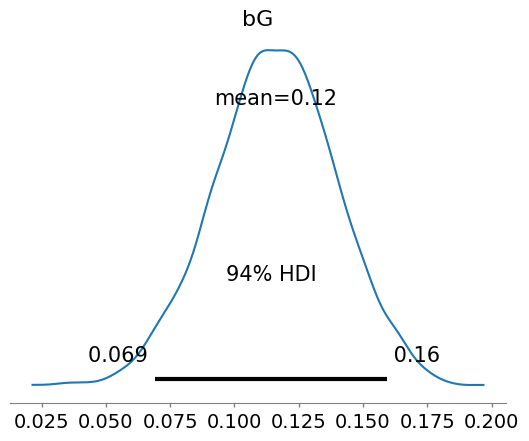

In [20]:
az.plot_posterior(MBG_FULL_trace,var_names=['bG'])

## Imputing Primates

Key idea: Missing values already have probability distributions

Think like a graph, not like a regression

Imputation without relationships among predictors risky

Even if doesn't change result, it's our duty